# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket: `s3://cis9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
%%info

In [2]:
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("scipy==1.7.1")
sc.install_pypi_package("seaborn==0.11.2")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1651365778622_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Now, import the installed packages from the previous block below.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [4]:
df = spark.read.json('s3://cis9760-emr-bucket/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|[,,,,,,,,,,, True...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|[,,,,,,,,, True,,...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|[8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

# Overview of Data

Display the number of rows and columns in our dataset.

In [58]:
print(f"Number of columns in Business table: {len(df.columns)}")
print(f"Number of rows in Business table: {df.count()}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in Business table: 14
Number of rows in Business table: 150346

Display the DataFrame schema below.

In [7]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [8]:
df.select("business_id", "name", "city", "state", "categories").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+-----+--------------------+
|         business_id|                name|         city|state|          categories|
+--------------------+--------------------+-------------+-----+--------------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|Santa Barbara|   CA|Doctors, Traditio...|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|       Affton|   MO|Shipping Centers,...|
|tUFrWirKiKi_TAnsV...|              Target|       Tucson|   AZ|Department Stores...|
|MTSW4McQd7CbVtyjq...|  St Honore Pastries| Philadelphia|   PA|Restaurants, Food...|
|mWMc6_wTdE0EUBKIG...|Perkiomen Valley ...|   Green Lane|   PA|Brewpubs, Breweri...|
+--------------------+--------------------+-------------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [9]:
# Install the necessary libraries here
from pyspark.sql.functions import explode, split

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df_cat=df.select("business_id", "categories")
df_cat.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|
|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|
|tUFrWirKiKi_TAnsV...|Department Stores...|
|MTSW4McQd7CbVtyjq...|Restaurants, Food...|
|mWMc6_wTdE0EUBKIG...|Brewpubs, Breweri...|
+--------------------+--------------------+
only showing top 5 rows

Display the first 5 rows of your association table below.

In [11]:
df_cat_exploded = df_cat.withColumn('categories',explode(split('categories',", ")))
df_cat_exploded.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|             Doctors|
|Pns2l4eNsfO8kk83d...|Traditional Chine...|
|Pns2l4eNsfO8kk83d...|Naturopathic/Holi...|
|Pns2l4eNsfO8kk83d...|         Acupuncture|
|Pns2l4eNsfO8kk83d...|    Health & Medical|
+--------------------+--------------------+
only showing top 5 rows

# Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [12]:
df_cat_exploded.select('categories').distinct().count()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1311

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [13]:
df_cat_grouped=df_cat_exploded.groupby("categories")
df_cat_grouped.count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|      Paddleboarding|   98|
|      Dermatologists|  336|
|         Hobby Shops|  552|
|          Bubble Tea|  477|
|             Embassy|    3|
|             Tanning|  667|
|            Handyman|  356|
|      Aerial Fitness|   19|
|             Falafel|  103|
|        Summer Camps|  232|
|       Outlet Stores|  182|
|     Clothing Rental|   37|
|      Sporting Goods| 1662|
|     Cooking Schools|   76|
|  Lactation Services|   27|
|Ski & Snowboard S...|   40|
|             Museums|  413|
|              Doulas|   31|
|                Food|27781|
|         Halotherapy|   23|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

If you want, you can also use seaborn library

In [14]:
df_cat_top = df_cat_grouped.count().sort("count", ascending = False)
df_cat_top.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows

In [15]:
bar_df=df_cat_top.toPandas()
bar_df[0:20]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   categories  count
0                 Restaurants  52268
1                        Food  27781
2                    Shopping  24395
3               Home Services  14356
4               Beauty & Spas  14292
5                   Nightlife  12281
6            Health & Medical  11890
7              Local Services  11198
8                        Bars  11065
9                  Automotive  10773
10  Event Planning & Services   9895
11                 Sandwiches   8366
12     American (Traditional)   8139
13                Active Life   7687
14                      Pizza   7093
15               Coffee & Tea   6703
16                  Fast Food   6472
17         Breakfast & Brunch   6239
18             American (New)   6097
19            Hotels & Travel   5857

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

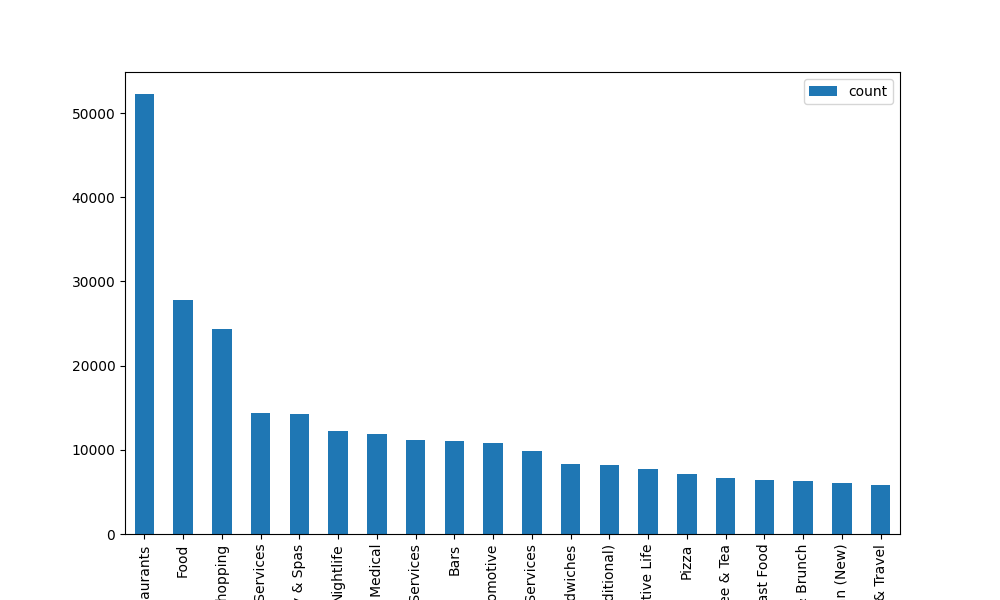

In [16]:
plt.figure(figsize =(10,6))
bar_df[0:20].plot(kind='bar', x='categories', figsize =(10,6))
%matplot plt

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available. `s3://cis9760-yelpdataset/yelp-light/*review.json`

In [17]:
review_df = spark.read.json('s3://cis9760-emr-bucket/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
review_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [19]:
review_df.select("business_id", "stars").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|XQfwVwDr-v0ZS3_Cb...|  3.0|
|7ATYjTIgM3jUlt4UM...|  5.0|
|YjUWPpI6HXG530lwP...|  3.0|
|kxX2SOes4o-D3ZQBk...|  5.0|
|e4Vwtrqf-wpJfwesg...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [20]:
from pyspark.sql.functions import mean
review_avgstar = review_df.select("business_id", "stars") \
    .groupBy("business_id") \
    .agg(mean('stars').alias("avg(stars)")) 
review_avgstar.show(5)    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|zJErbOQMKX-MwHs_u...|2.9279279279279278|
|RZ-FNTXvqHKngyLGD...|2.8823529411764706|
|HSzSGdcNaU7heQe0N...|3.3333333333333335|
|skW4boArIApRw9DXK...|2.3947368421052633|
|I0053JmJ5DEFUWSJ8...|2.3956043956043955|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [21]:
df_bus = df.select("business_id", "name", "city", "state", "stars")
rv_bus = df_bus.join(review_avgstar, df_bus.business_id == review_avgstar.business_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [22]:
rv_bus.select("name", "city", "state", "avg(stars)", "stars").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+-----+------------------+-----+
|                name|        city|state|        avg(stars)|stars|
+--------------------+------------+-----+------------------+-----+
|Philadelphia Marr...|Philadelphia|   PA|2.9279279279279278|  3.0|
|Gaetano's of West...| West Berlin|   NJ|2.8823529411764706|  3.0|
|Gillane's Bar & G...|     Ardmore|   PA|3.3333333333333335|  3.0|
|Champps Penn's La...|Philadelphia|   PA|2.3947368421052633|  2.5|
|Golden Corral Buf...|      Tucson|   AZ|2.3956043956043955|  2.5|
+--------------------+------------+-----+------------------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [23]:
from pyspark.sql.functions import col
rv_bus=rv_bus.withColumn("skew", (col('avg(stars)')- col('stars')) / col('stars'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
rv_bus.select("name", "city", "state", "avg(stars)", "stars", "skew").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+-----+------------------+-----+--------------------+
|                name|        city|state|        avg(stars)|stars|                skew|
+--------------------+------------+-----+------------------+-----+--------------------+
|Gillane's Bar & G...|     Ardmore|   PA|3.3333333333333335|  3.0| 0.11111111111111116|
|Champps Penn's La...|Philadelphia|   PA|2.3947368421052633|  2.5|-0.04210526315789469|
|Philadelphia Marr...|Philadelphia|   PA|2.9279279279279278|  3.0|-0.02402402402402...|
|Golden Corral Buf...|      Tucson|   AZ|2.3956043956043955|  2.5|-0.04175824175824179|
|  Swiss Watch Center|       Tampa|   FL| 3.357142857142857|  3.5|-0.04081632653061223|
+--------------------+------------+-----+------------------+-----+--------------------+
only showing top 5 rows

In [25]:
rv_bus_df = rv_bus.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

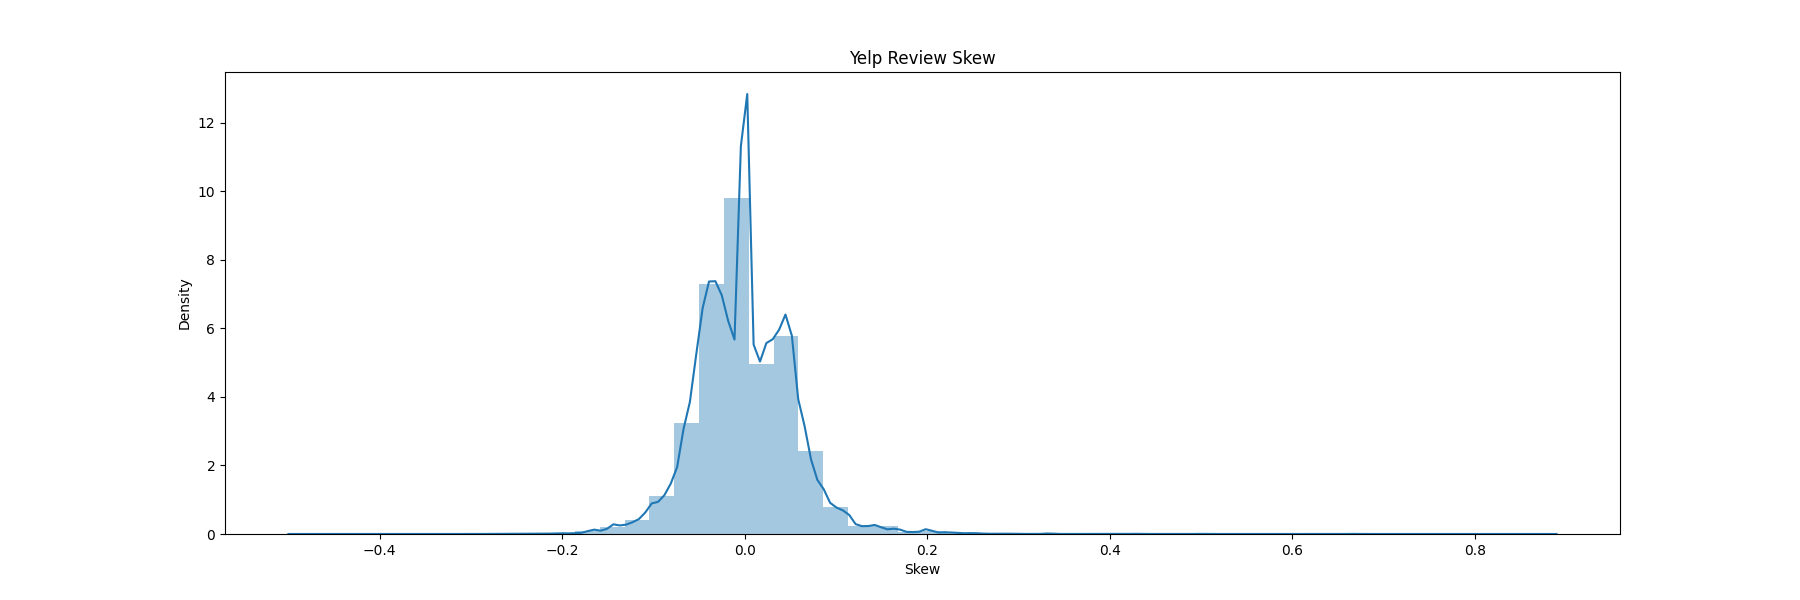

In [26]:
plt.figure(figsize =(18,6))
sns.distplot(rv_bus_df["skew"], axlabel = "Skew", kde = True).set(title = "Yelp Review Skew")
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

### IMPLICATIONS

**Type your answer here:** 
    As the graph shows, denisty on the left side is greater than one on the right side, which means that there are more negative Yelp (written) Reviews skews than the positive ones. So at this point, we can interpret that reviewers who left a written response were more dissatisfied than normal.

# Should the Elite be Trusted?

How accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating? `s3://cis9760-yelpdataset/yelp-light/*user.json`

Feel free to use any and all methodologies at your disposal. 
You must render one visualization in your analysis and interpret your findings.

In [27]:
user_df = spark.read.json('s3://cis9760-emr-bucket/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
user_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [29]:
user_review = user_df.join(review_df, user_df.user_id == review_df.user_id)
user_review.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 'name', 'review_count', 'useful', 'user_id', 'yelping_since', 'business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id']

In [41]:
#Average stars for each business_id
from pyspark.sql.functions import mean
busrating = user_review.select("business_id", "stars") \
    .groupBy("business_id") \
    .agg(mean('stars').alias("avg(stars)")) 
busrating.show(5)    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|C9KvsTqi617Yg_sNj...| 4.510204081632653|
|wopwoiKIllIzcggK7...| 3.205521472392638|
|yqq1Fvt7WtduIO3Gw...|2.9473684210526314|
|3FKIev7ZB_KE6XHL9...|3.8637362637362638|
|nC-dCuPytssHAaMkA...|               3.4|
+--------------------+------------------+
only showing top 5 rows

In [43]:
#Elite users' stars on each business_id
usersrating = user_review.select(user_df.user_id, "stars", "business_id") \
    .filter(user_review.elite != "")
usersrating.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+
|             user_id|stars|         business_id|
+--------------------+-----+--------------------+
|IeSz60ozr1yAVIH8C...|  4.0|TV81bpCQ6p6o4Hau5...|
|xW2A0MciHB0pLB4RH...|  5.0|W4ZEKkva9HpAdZG88...|
|SSafXe2aUO0cXgQhE...|  5.0|E-4t5Hoon6aVFTWDP...|
|yiYUEExKfZEv_T8CF...|  3.0|_pbx96FZ3eHJw-V_R...|
|A3EiqW7_k00gvaiQi...|  5.0|8uF-bhJFgT4Tn6DTb...|
|Zsucq1c-sjuGxs5jZ...|  4.0|zaC6coZ5Gp8mLjeg7...|
|aX3vDE1UmbdrWeOsg...|  5.0|EqEcDeXqIq1YwnzHg...|
|aHiQYaTXrmQTeG610...|  4.0|3w7NRntdQ9h0KwDsk...|
|g34Qcj06LmCDhKzks...|  5.0|yE1raqkLX7OZsjmX3...|
|yiYUEExKfZEv_T8CF...|  4.0|EP2jFD3aGoSBCWb7i...|
|OTG7-L3N4geWEB_0q...|  4.0|hS6KNGCQVTYUdLb2e...|
|xHU37ocClTtu1rS4L...|  5.0|uW8L6awmCyjovD9Oh...|
|wwoLHw7FX0CaeOmw1...|  4.0|6kAXOzE7fqaBZINQV...|
|Zsucq1c-sjuGxs5jZ...|  5.0|yLIn3po-fKb0T3UIo...|
|417svAEVHreK6c3SK...|  3.0|oQ5CPRt0R3AzFvcjN...|
|qCNZXu0nA1m9_qQDS...|  3.0|psI9u_iVuWFcchWhe...|
|wwoLHw7FX0CaeOmw1...|  5.0|wzE61ThXOdrSegvwS...|


In [45]:
#Join them
users_bus = usersrating.join(busrating, usersrating.business_id == busrating.business_id)
users_bus.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+-----------------+
|             user_id|stars|         business_id|         business_id|       avg(stars)|
+--------------------+-----+--------------------+--------------------+-----------------+
|fen9BWC39ul9SJZfQ...|  4.0|--gJkxbsiSIwsQKbi...|--gJkxbsiSIwsQKbi...|4.833333333333333|
|7jOaJw3txVFlkHB7Y...|  5.0|-02xFuruu85XmDn2x...|-02xFuruu85XmDn2x...| 4.68595041322314|
|_VZlDBtCT_Qb3_OOT...|  5.0|-02xFuruu85XmDn2x...|-02xFuruu85XmDn2x...| 4.68595041322314|
|EO7u_L1_ZgRdawMrb...|  5.0|-02xFuruu85XmDn2x...|-02xFuruu85XmDn2x...| 4.68595041322314|
|2gyrlO8oOuGf5JMOe...|  5.0|-02xFuruu85XmDn2x...|-02xFuruu85XmDn2x...| 4.68595041322314|
|mmSvRe11vbz3XTXw5...|  5.0|-02xFuruu85XmDn2x...|-02xFuruu85XmDn2x...| 4.68595041322314|
|UtpU2qK1p1rmAZpwr...|  5.0|-02xFuruu85XmDn2x...|-02xFuruu85XmDn2x...| 4.68595041322314|
|Mu5xg6ZESWCp3rnry...|  5.0|-02xFuruu85XmDn2x...|-02xFuruu85XmDn2x...| 4.68595041322314|
|I06gY9An4o81XpejL...

In [49]:
#Create a new column (stars_diff)
from pyspark.sql.functions import col
users_bus = users_bus.withColumn("stars_diff", col("stars") - col("avg(stars)"))
users_bus.sort("stars_diff", ascending = False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+------------------+------------------+
|             user_id|stars|         business_id|         business_id|        avg(stars)|        stars_diff|
+--------------------+-----+--------------------+--------------------+------------------+------------------+
|CYsL9QLOpuucO-vJJ...|  5.0|CxmqP1eRI1g4TNnzZ...|CxmqP1eRI1g4TNnzZ...|1.0597014925373134|3.9402985074626864|
|MmEYowrsA4j3K4gc9...|  5.0|Rmhr3u3Bb5XQReVXl...|Rmhr3u3Bb5XQReVXl...|               1.1|               3.9|
|QJI9OSEn6ujRCtrX0...|  5.0|O_op1voFpnHEHho-2...|O_op1voFpnHEHho-2...|1.1481481481481481| 3.851851851851852|
|IB2Zyn6ak7wt4YN-j...|  5.0|SodX2x5WpHYetiVEL...|SodX2x5WpHYetiVEL...|1.1626794258373205|3.8373205741626792|
|Vwslifegl59fQVOe5...|  5.0|LQvZUpDkm07K5UE8K...|LQvZUpDkm07K5UE8K...|1.1756756756756757|3.8243243243243246|
|jEcSGHkE31zEGt7p_...|  5.0|DuB7UztTWu1eDfEaB...|DuB7UztTWu1eDfEaB...|1.1851851851851851| 3.814814814814815|
|YcSDGPRj-cmmadlaJ.

In [47]:
#Convert the column "stars_diff" to a pandas dataframe
diff_df = users_bus.select("stars_diff").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

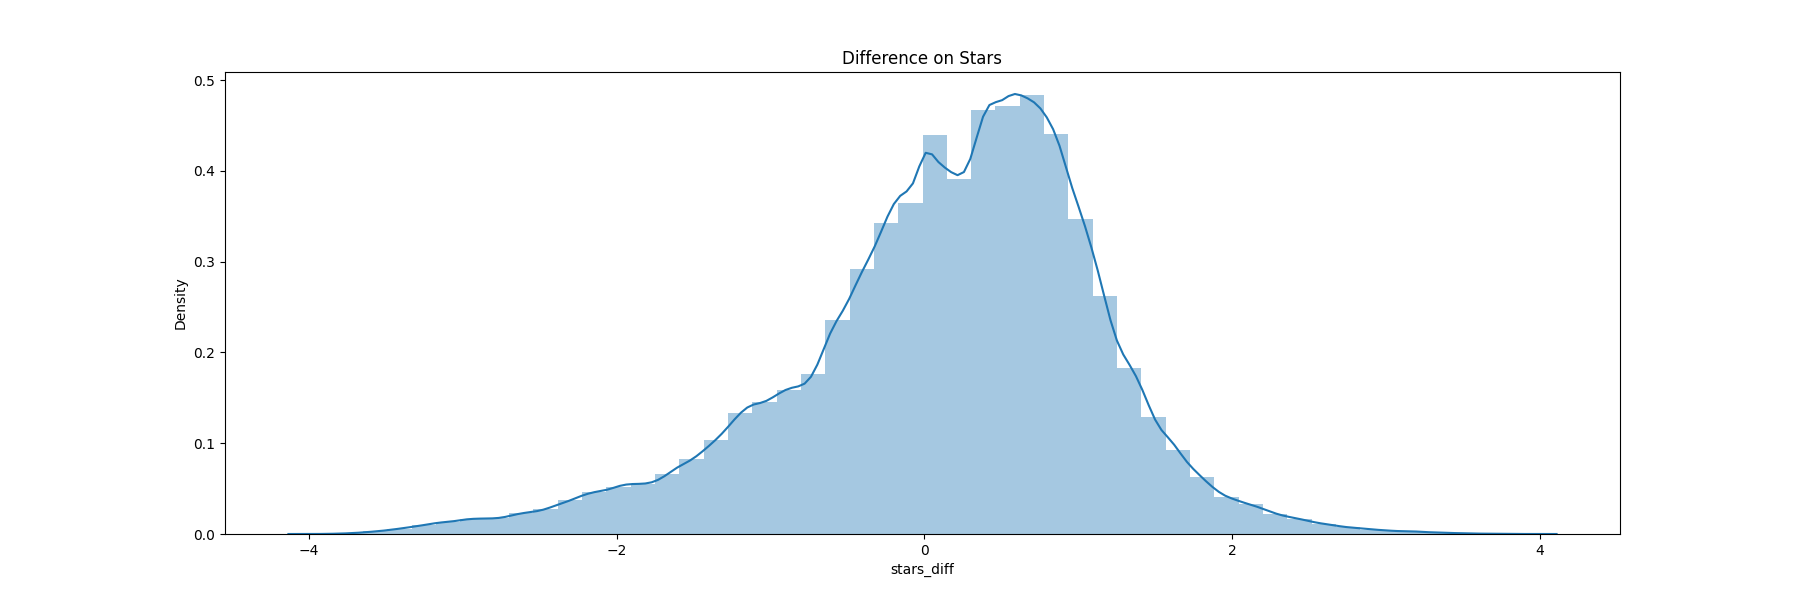

In [51]:
plt.figure(figsize =(18,6))
#from scipy.stats import norm
sns.distplot(diff_df, axlabel = "stars_diff", kde = True).set(title = "Difference on Stars")
%matplot plt

# IMPLICATIONS

As the graph shows, differance mainly ranges from -4 from 4, the graph tends to spread out to both sides , which indicates that the difference between elite users' rating and the business average rating is quite large on the whole, they are not close to each other, so at this point, we can not take an elite user's review as reference to tell if a business is good or not.

# Extra Credit (3 points)

Try and analyze some interesting dimension to this data. 
**Requirements:**

You must use the **Users** dataset and join on either the "**business** or **reviews** dataset.

You must render **one visual**

#   More Reviewers Means a Higher Star for a Business?

In [83]:
#Number of reviewers for each business_id
from pyspark.sql.functions import count
reviewersnum = user_review.select("business_id", user_df.user_id) \
    .groupby("business_id") \
    .agg(count(user_df.user_id).alias("number of reviewers"))
reviewersnum.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+
|         business_id|number of reviewers|
+--------------------+-------------------+
|yqq1Fvt7WtduIO3Gw...|                 76|
|zJErbOQMKX-MwHs_u...|                222|
|XH3mYdTg4ZxWV-8W7...|                 18|
|oQ0MQpVVyzGe_JTIL...|                 46|
|ZFaG1Q3voENwwZPQA...|                 14|
|jzsspHqP9kATWji8x...|                144|
|skW4boArIApRw9DXK...|                 38|
|sbYIQC5k2hVAqagH8...|                 88|
|nGe0BipegbPjll9tG...|                220|
|DeDszlU-Gg-Hodu_H...|                 11|
|519hm725XtfGaK_7b...|                 30|
|BJOGo_upuBElDT_xO...|                501|
|dugSltSoiYMwQvttp...|                 46|
|jg02zYvPsUGyHQBlK...|                 33|
|ZamcoxNtToUXvMvwF...|                 31|
|7Y1bCJLDE8surUcI1...|                  8|
|3FKIev7ZB_KE6XHL9...|                455|
|-JAwNIEJoDXmdE_8s...|                120|
|WOPAPwhaPqQg0cn4t...|                 26|
|P4E0Lv494T0OvvupB...|                 89|
+----------

In [84]:
#busrating created from Part IV
num_vs_stars = busrating.join(reviewersnum, busrating.business_id == reviewersnum.business_id)
num_vs_stars.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+--------------------+-------------------+
|         business_id|        avg(stars)|         business_id|number of reviewers|
+--------------------+------------------+--------------------+-------------------+
|--gJkxbsiSIwsQKbi...| 4.833333333333333|--gJkxbsiSIwsQKbi...|                  6|
|-02xFuruu85XmDn2x...|  4.68595041322314|-02xFuruu85XmDn2x...|                121|
|-0EdehHjIQc0DtYU8...| 3.138888888888889|-0EdehHjIQc0DtYU8...|                 36|
|-0dKgi_Hpcis921nO...| 4.678571428571429|-0dKgi_Hpcis921nO...|                 28|
|-0iIxySkp97WNlwK6...| 3.721030042918455|-0iIxySkp97WNlwK6...|                233|
|-0qOecqGXEf_6Twai...| 4.238095238095238|-0qOecqGXEf_6Twai...|                 42|
|-1ze-oWDnrGAzvAg5...|               5.0|-1ze-oWDnrGAzvAg5...|                 12|
|-2j8XqQL68DPqYiaf...|               5.0|-2j8XqQL68DPqYiaf...|                  7|
|-2wh7NTLkWEgsrLJv...| 4.416666666666667|-2wh7NTLkWEgsrLJv...|                 96|
|-3e

In [89]:
from pyspark.sql.types import StringType
num_vs_stars.withColumn("number of reviewers", col("number of reviewers").cast(StringType()))
num_vs_stars.sort("number of reviewers", ascending = False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+--------------------+-------------------+
|         business_id|        avg(stars)|         business_id|number of reviewers|
+--------------------+------------------+--------------------+-------------------+
|_ab50qdWOk0DdB6XO...| 4.124983709109865|_ab50qdWOk0DdB6XO...|               7673|
|ac1AeYqs8Z4_e2X5M...| 4.146221394358702|ac1AeYqs8Z4_e2X5M...|               7516|
|GXFMD0Z4jEVZBCsbP...|4.4462662337662335|GXFMD0Z4jEVZBCsbP...|               6160|
|ytynqOUb3hjKeJfRj...|  4.60539979231568|ytynqOUb3hjKeJfRj...|               5778|
|oBNrLz4EDhiscSlbO...|4.2912234042553195|oBNrLz4EDhiscSlbO...|               5264|
|iSRTaT9WngzB8JJ2Y...|3.4387133612485723|iSRTaT9WngzB8JJ2Y...|               5254|
|VQcCL9PiNL_wkGf-u...|3.7866303925378935|VQcCL9PiNL_wkGf-u...|               5146|
|_C7QiQQc47AOEv4PE...|  4.29201046488227|_C7QiQQc47AOEv4PE...|               4969|
|GBTPC53ZrG1ZBY3DT...| 4.177429736108131|GBTPC53ZrG1ZBY3DT...|               4661|
|6a4

In [92]:
scatter_df = num_vs_stars.select("number of reviewers", "avg(stars)").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

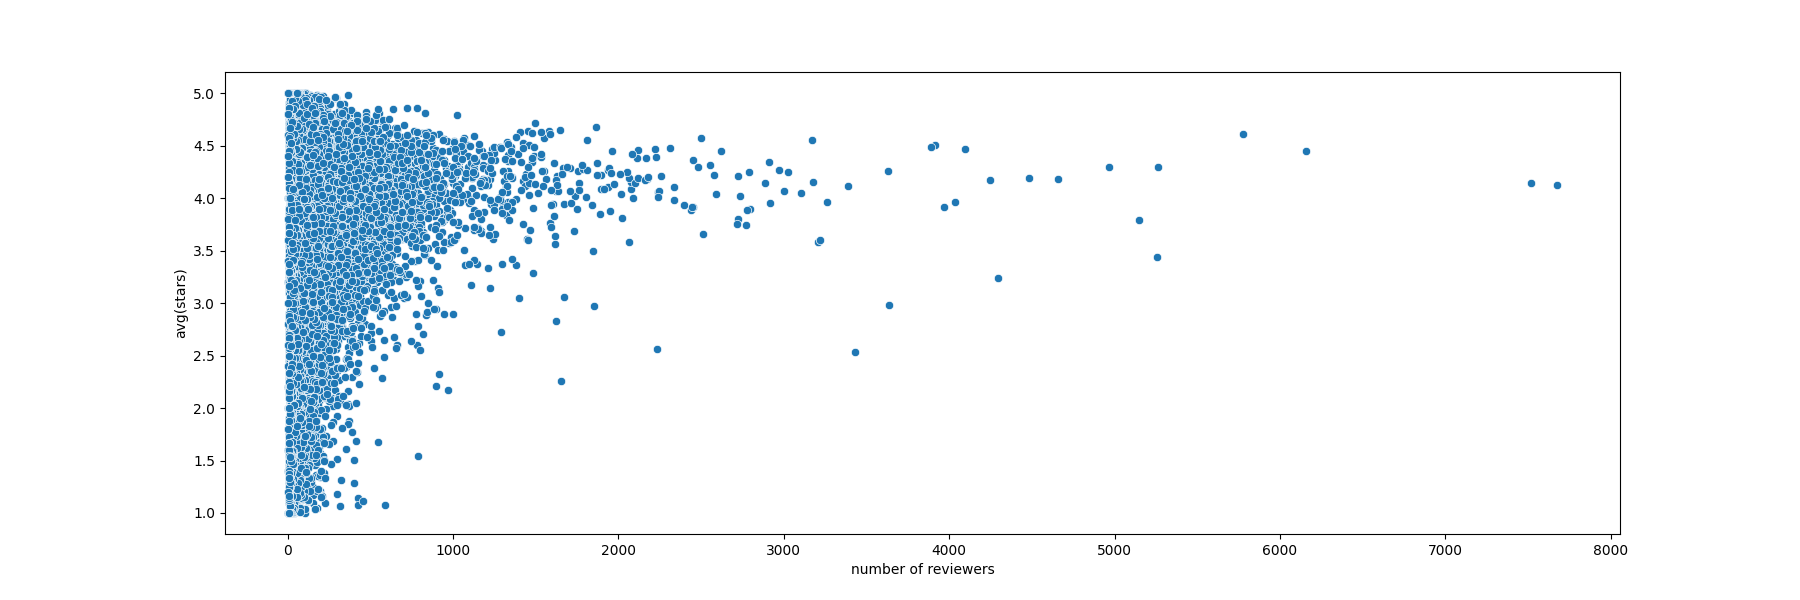

In [91]:
#Scatter plot
plt.figure(figsize =(18,6))
#from scipy.stats import norm
sns.scatterplot(data=scatter_df, x="number of reviewers", y="avg(stars)")
%matplot plt

# IMPLICATIONS

The graph does not explicitly indicate the correlation between number of reviewers and stars of a business, however, we still can tell that as the reviewers increase, a business has more possibility to get a higher star.

# Top 20 Business Names Having Most Reviews from Elite Users

In [34]:
#Join users table and review table
user_review = user_df.join(review_df, user_df.user_id == review_df.user_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
#Get reviews by elite users
elite_rev = user_review.select("business_id", "elite", "stars") \
    .filter(user_review.elite != "")
elite_rev.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+
|         business_id|               elite|stars|
+--------------------+--------------------+-----+
|TV81bpCQ6p6o4Hau5...|2017,2018,2019,20...|  4.0|
|W4ZEKkva9HpAdZG88...|2014,2015,2016,20...|  5.0|
|E-4t5Hoon6aVFTWDP...|2014,2015,2016,20...|  5.0|
|_pbx96FZ3eHJw-V_R...|                2015|  3.0|
|8uF-bhJFgT4Tn6DTb...|          2019,20,20|  5.0|
|zaC6coZ5Gp8mLjeg7...|2011,2012,2013,20...|  4.0|
|EqEcDeXqIq1YwnzHg...|2018,2019,20,20,2021|  5.0|
|3w7NRntdQ9h0KwDsk...|2012,2013,2014,20...|  4.0|
|yE1raqkLX7OZsjmX3...|2017,2018,2019,20,20|  5.0|
|EP2jFD3aGoSBCWb7i...|                2015|  4.0|
|hS6KNGCQVTYUdLb2e...|2018,2019,20,20,2021|  4.0|
|uW8L6awmCyjovD9Oh...|           2014,2015|  5.0|
|6kAXOzE7fqaBZINQV...|           2017,2018|  4.0|
|yLIn3po-fKb0T3UIo...|2011,2012,2013,20...|  5.0|
|oQ5CPRt0R3AzFvcjN...|2018,2019,20,20,2021|  3.0|
|psI9u_iVuWFcchWhe...| 2006,2007,2008,2010|  3.0|
|wzE61ThXOdrSegvwS...|           2017,2018|  5.0|


In [36]:
#Group the datafram, get count
elite_rev_grouped = elite_rev.groupby("business_id")
elite_rev_grouped.count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|count|
+--------------------+-----+
|zJErbOQMKX-MwHs_u...|   86|
|HSzSGdcNaU7heQe0N...|   11|
|skW4boArIApRw9DXK...|   15|
|I0053JmJ5DEFUWSJ8...|   23|
|kPG6r0h73sPgXBei0...|   31|
|Ety2Z0CImO6FYDV6L...|   29|
|Qbxo9pb5yDsbD3GSu...|   21|
|whUR7TFShhEhPT0X2...|    4|
|Yh_KhyVD6ZBwsIQQ1...|   58|
|H94SJrxs9Fx-WYUSm...|    1|
|64i1xdiU1Wvo1Cuu0...|   28|
|9-uRQkRkXdPQmnU1o...|   33|
|3I3YM0yD2jaXZTK3Y...|    7|
|0YiRkVMR2cg17hk9u...|    5|
|scychO44eMoosS9iE...|    3|
|xR1Wkmrm3yoAJuxPm...|   20|
|EyBlARgBUFBu6ZYS9...|   34|
|gZqFuqTjtN4Bfh-_f...|   65|
|pP4q0Mym-qt20nRqT...|   62|
|lXCFcmhoRsyW-mnzz...|   36|
+--------------------+-----+
only showing top 20 rows

In [37]:
#Sort it
top_bus_eliterev = elite_rev_grouped.count().sort("count", ascending = False)
top_bus_eliterev.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|count|
+--------------------+-----+
|_ab50qdWOk0DdB6XO...| 2330|
|ytynqOUb3hjKeJfRj...| 1955|
|GXFMD0Z4jEVZBCsbP...| 1790|
|_C7QiQQc47AOEv4PE...| 1568|
|PP3BBaVxZLcJU54uP...| 1520|
|iSRTaT9WngzB8JJ2Y...| 1462|
|GBTPC53ZrG1ZBY3DT...| 1402|
|ac1AeYqs8Z4_e2X5M...| 1368|
|6a4gLLFSgr-Q6CZXD...| 1340|
|gTC8IQ_i8zXytWSly...| 1288|
|-QI8Qi8XWH3D8y8et...| 1257|
|VaO-VW3e1kARkU9bP...| 1169|
|Eb1XmmLWyt_way5NN...| 1162|
|VVH6k9-ycttH3TV_l...| 1158|
|1b5mnK8bMnnju_cvU...| 1153|
|I_3LMZ_1m2mzR0oLI...| 1149|
|6Ty-KKWq6hLZYW8DW...| 1138|
|IkY2ticzHEn4QFn8h...| 1131|
|oBNrLz4EDhiscSlbO...| 1110|
|VQcCL9PiNL_wkGf-u...| 1093|
+--------------------+-----+
only showing top 20 rows

In [38]:
#Join the business table, get the name field
bus_name_df = df.select("business_id", "name")
top_bus_eliterev = top_bus_eliterev.join(bus_name_df, top_bus_eliterev.business_id == bus_name_df.business_id)
top_bus_eliterev.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+
|         business_id|count|         business_id|                name|
+--------------------+-----+--------------------+--------------------+
|_ab50qdWOk0DdB6XO...| 2330|_ab50qdWOk0DdB6XO...|   Acme Oyster House|
|ytynqOUb3hjKeJfRj...| 1955|ytynqOUb3hjKeJfRj...|Reading Terminal ...|
|GXFMD0Z4jEVZBCsbP...| 1790|GXFMD0Z4jEVZBCsbP...|Hattie B’s Hot Ch...|
|_C7QiQQc47AOEv4PE...| 1568|_C7QiQQc47AOEv4PE...|  Commander's Palace|
|PP3BBaVxZLcJU54uP...| 1520|PP3BBaVxZLcJU54uP...|Pat's King of Steaks|
|iSRTaT9WngzB8JJ2Y...| 1462|iSRTaT9WngzB8JJ2Y...| Mother's Restaurant|
|GBTPC53ZrG1ZBY3DT...| 1402|GBTPC53ZrG1ZBY3DT...|                Luke|
|ac1AeYqs8Z4_e2X5M...| 1368|ac1AeYqs8Z4_e2X5M...|        Oceana Grill|
|6a4gLLFSgr-Q6CZXD...| 1340|6a4gLLFSgr-Q6CZXD...|              Cochon|
|gTC8IQ_i8zXytWSly...| 1288|gTC8IQ_i8zXytWSly...|      Cochon Butcher|
|-QI8Qi8XWH3D8y8et...| 1257|-QI8Qi8XWH3D8y8et...|Philadelphia Inte...|
|VaO-V

In [39]:
#Convert to pandas dataframe
top_bus_eliterev = top_bus_eliterev.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

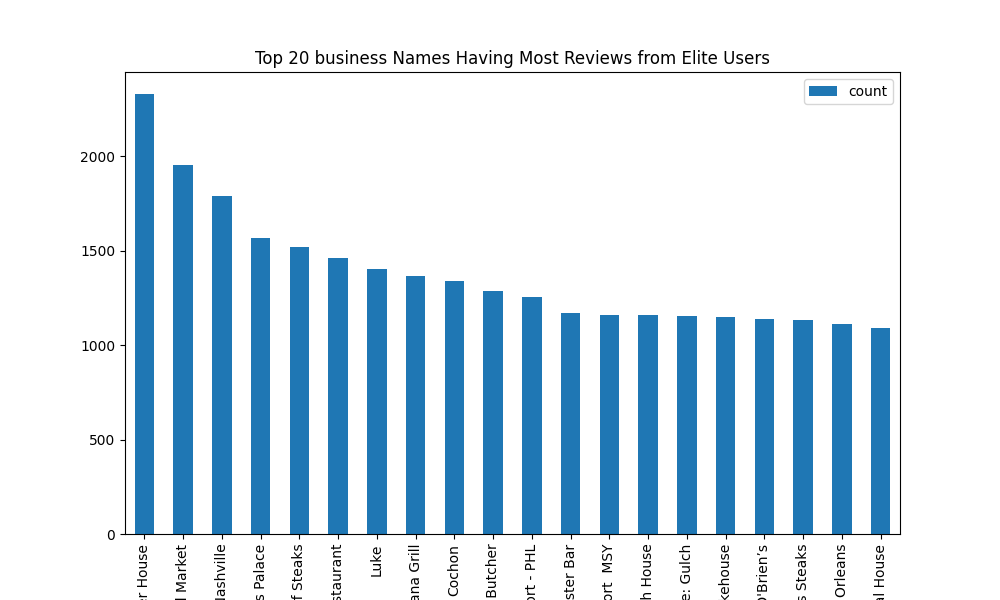

In [40]:
#Plot a bar chart
plt.figure(figsize =(10,6))
top_bus_eliterev[0:20].plot(kind='bar', x='name', figsize =(10,6)) \
    .set(title = "Top 20 business Names Having Most Reviews from Elite Users")
%matplot plt